In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns
import pathlib

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [ ]:
from zipfile import ZipFile

# opening the zip file in read me mode
with ZipFile('/content/drive/MyDrive/banana/banana.zip', 'r') as zip :
  print("Extracting the files...")
  zip.extractall()
  print("Done")

Extracting the files...
Done


In [ ]:
path = '/content/banana_classification/train' # change data here
data_dir = pathlib.Path(path)

# Get filepaths and labels
filepaths = list(data_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/content/banana_classification/train/rotten/mu...,rotten
1,/content/banana_classification/train/ripe/musa...,ripe
2,/content/banana_classification/train/ripe/musa...,ripe


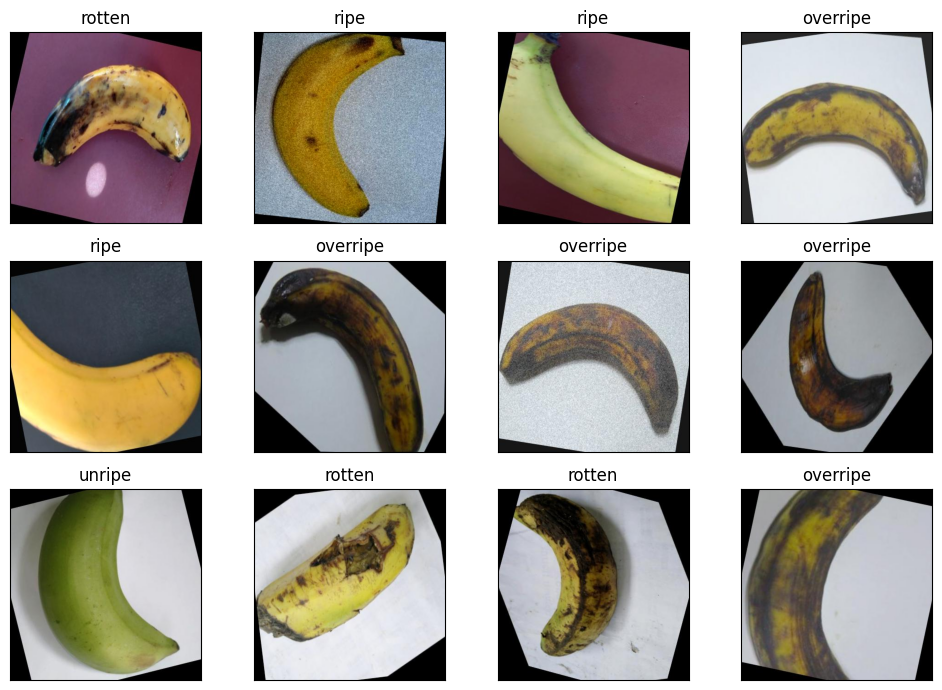

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

<ipython-input-7-9009e362abea>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


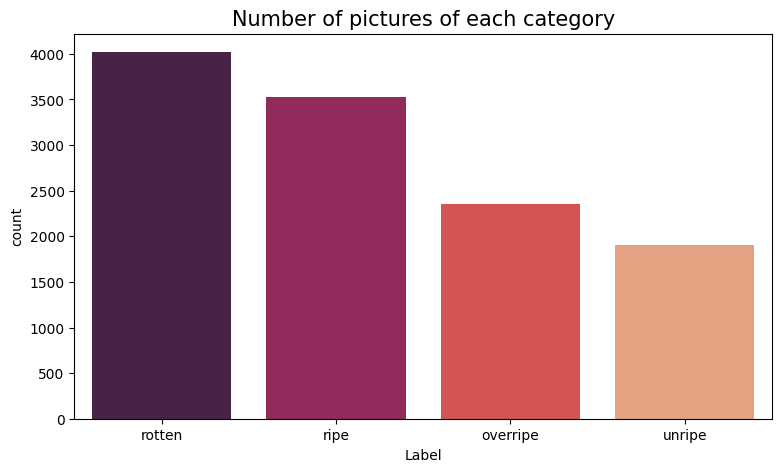

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='training',
        rotation_range=100, # Uncomment to use data augmentation
        zoom_range=0.05,
        width_shift_range=0.5,
        height_shift_range=0.5,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=100, # Uncomment to use data augmentation
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
# in term of need the validation

# X_train, X_test, y_train, y_test
#     = train_test_split(X, y, test_size=0.2, random_state=1)

#  X_train, X_val, y_train, y_val
#     = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 6604 validated image filenames belonging to 4 classes.
Found 1651 validated image filenames belonging to 4 classes.
Found 3538 validated image filenames belonging to 4 classes.




In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(64, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

rlronp=tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=100,
    callbacks=[rlronp],
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.5250 - loss: 0.5094 - val_accuracy: 0.9231 - val_loss: 0.1420
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8480 - loss: 0.2269 - val_accuracy: 0.9291 - val_loss: 0.1000
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8968 - loss: 0.1574 - val_accuracy: 0.9419 - val_loss: 0.0866
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9209 - loss: 0.1288 - val_accuracy: 0.9473 - val_loss: 0.0866
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 254ms/step - accuracy: 0.9248 - loss: 0.1188 - val_accuracy: 0.9552 - val_loss: 0.0730
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.9351 - loss: 0.1010 - val_accuracy: 0.9558 - val_loss: 0.0658
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.9486 - loss: 0.0917 - val_accuracy: 0.9624 - val_loss: 0.0668
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9470 - loss: 0.0854 - va

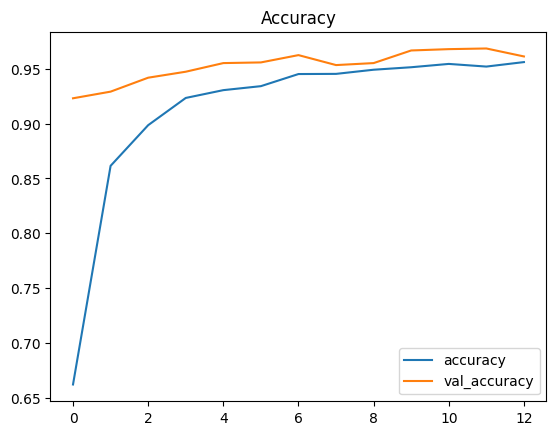

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

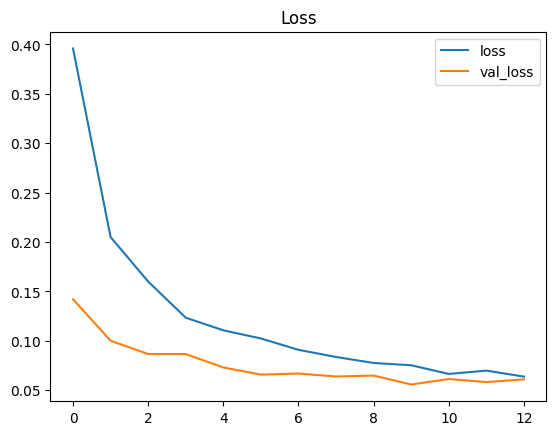

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.04508

## Accuracy on the test set: 97.29%

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step
The first 5 predictions: ['unripe', 'rotten', 'rotten', 'unripe', 'rotten']


In [ ]:
model.save('/content/drive/MyDrive/banana/banana_model.h5')

In [ ]:
print(tf.version.VERSION)
print(tf.keras.__version__)

2.17.0
3.4.1
